# Exploring Student Satisfication with Remote Learning and Perceived Academic Performance

## 1. Background
### 1.1 Introduction 
Despite efforts to push full-on face-to-face classes, many schools in the Philippines remained hesitant to implement them due to the risks of COVID-19. For some academic institutions, however, the option was to either adapt a hybrid system and eventually shift back to in-person learning once the pandemic had subsided or to accept distance learning as the new normal.

As we reflected on the challenges faced by students in a remote learning environment, several key issues emerged. These included unreliable internet connectivity and the absence of appropriate learning devices, which hindered participation in synchronous classes and the submission of course requirements (Baticulon et al., 2020; Santos, 2020). Negative experiences such as limited engagement in synchronous lectures, increased distractions, difficulties in comprehending lessons, and delays in the exchange of responses and feedback also significantly impacted their overall learning experience (Bai et al., 2021). Furthermore, two surveys conducted by the UP System Committee on Remote Teaching and Learning in November 2020 and July 2021 revealed that 80% of students felt academically overwhelmed, while only 30% expressed satisfaction with their learning experiences (Lontoc, 2021).

In response to this dilemma, it is crucial to evaluate the academic effectiveness of prior remote learning systems to assist administrations in their decision-making processes. As highlighted by Joaquin et al. (2020), learning innovations must have a deeper understanding of what remote education is by looking at factors such as instructor’s capacity, student’s circumstance, and learning environment efficiency together with the more evident issues of network connection speed, cost of materials, and mode of instruction.

### 1.2. Objectives

The main objective of this report was to analyze survey data of University of the Philippines (UP) undergraduate students using descriptive, correlation, and factor analyses. Specifically, it aims to:
             
1.	Describe respondents by demographics, student satisfaction with remote learning, and perceived academic performance.
3.	Examine relationships between demographics, student satisfaction, and academic performance.
4.	Identify the best latent factor structure for student satisfaction with remote learning.

## 2. Exploratory Data Analysis (EDA)

An online survey was used to collect data near the end of the first semester of Academic Year 2021-2022. Convenience sampling was employed due to limited resources, time, and the exploratory nature of the study. The participants included 150 undergraduate students from the UP System who were enrolled at the time. The survey data includes the following three sections:

In [8]:
## Import data from CSV file
library(tidyverse) # required library
data <- read_csv("data/survey_data.csv", show_col_types = FALSE)


## Create functions to be used
library(dplyr) # required library

# Tabularize a dataframe

library(DT)
summarize_variable <- function(data, variable=NULL, caption=NULL, dom="t", searching=FALSE, rownames=FALSE, pageLength=10) {
  if (is.null(variable)) {
    datatable(data, 
                  class="cell-border stripe", 
                  options = list(dom=dom, searching=searching, pageLength=pageLength),
                  rownames=rownames,
                  caption=if (!is.null(caption)) htmltools::tags$caption(
                    style = 'caption-side: top; text-align: center;',
                    caption
                  ) else NULL)
  } else {
	summarized_data <- data %>%
      filter(!!sym(variable) != "No Data") %>%
      group_by(!!sym(variable)) %>%
      summarise(Count = n(), .groups="drop") %>%
      {
        if (is.ordered(data[[variable]])) {
          arrange(., desc(!!sym(variable)))
        } else {
          arrange(., desc(Count))
        }
      } %>%
      mutate(Percentage = label_percent(accuracy=0.01)(Count/sum(Count)))
    
    datatable(summarized_data %>% rename(!!variable := !!sym(variable)),
                  class="cell-border stripe", 
                  options = list(dom=dom, searching=searching, pageLength=pageLength),
			      rownames=rownames,
                  caption=if (!is.null(caption)) htmltools::tags$caption(
                    style = 'caption-side: top; text-align: center;',
                    caption
                  ) else NULL)
  }
}

              


# Create horizontal bar plot using base R graphics    
library(rlang) # required library               
horiz_barplot <- function(data,
                          variable,
                          summ_var = NULL,
                          summ_fun = "n",
                          na.rm = TRUE,
                          others = FALSE,
                          others.p = NULL,
                          mar = c(5.1, 4.1, 4.1, 2.1),
                          col = "steelblue",
                          title = NULL,
                          xlab = NULL,
                          ylab = NULL,
                          xlim_adj = 0,
                          ...) {

  # --- 1. Data Summarization ---

  # Use dplyr::count() for simple counts.
  if (is.null(summ_fun) || summ_fun == "n" || is.null(summ_var)) {
    summary_col_name <- "Count"
    
    summarized_data <- data %>%
      count(.data[[variable]], name = summary_col_name, sort = TRUE)

  } else {
    # Handle other summary functions (mean, median, etc.)
    summary_col_name <- paste(summ_fun, summ_var, sep = "_")
    
    summarized_data <- data %>%
      group_by(.data[[variable]]) %>%
      summarize(
        !!summary_col_name := get(summ_fun)(.data[[summ_var]], na.rm = na.rm),
        .groups = "drop"
      ) %>%
      arrange(desc(.data[[summary_col_name]]))
  }
  
  # --- 2. "Others" Grouping ---
  if (others && !is.null(others.p)) {
    
    # Identify which rows to keep and which to group into "Others"
    to_keep <- summarized_data %>% filter(.data[[summary_col_name]] > others.p)
    to_group <- summarized_data %>% filter(.data[[summary_col_name]] <= others.p)
    
    # Only proceed if there are categories to group
    if (nrow(to_group) > 0) {
      others_row <- tibble(
        # Set the category name to "Others"
        !!variable := "Others",
        # Sum the values of the grouped categories
        !!summary_col_name := sum(to_group[[summary_col_name]])
      )
      
      # Combine the rows to keep with the new "Others" row
      summarized_data <- bind_rows(to_keep, others_row)
    }
  }

  # --- 3. Prepare Data for Base R Plotting ---
  # `barplot` requires a named vector.
  
  # Ensure the variable column is character for naming
  summarized_data[[variable]] <- as.character(summarized_data[[variable]])
  
  # Create the named vector
  summary_vec <- setNames(summarized_data[[summary_col_name]], summarized_data[[variable]])
  
  # Reverse the vector so the largest bar is at the top of the plot
  summary_vec <- rev(summary_vec)

  # --- 4. Generate Base R Plot ---
  
  # Set graphical margins
  par(mar = mar)
  
  # Display the bar plot
  bar_midpoints <- barplot(
    height = summary_vec,
    col = col,
    horiz = TRUE,
    las = 1, # Make category labels horizontal
    xlab = xlab,
    ylab = ylab,
    xlim = c(0, max(summary_vec) + xlim_adj),
    ...
  )
  
  # Add title and text labels for the bar values
  title(main = title, adj = 0, ...)
  text(
    x = summary_vec,
    y = bar_midpoints,
    labels = round(summary_vec, 1), # Round labels for cleanliness
    pos = 4, # Position labels to the right of the bars
    ...
  )
  
  # Return the bar midpoints, which can be useful
  invisible(bar_midpoints)
}

              
## Data Understanding

# View the data
head(data)
tail(data)

# View column names
colnames(data)

# Display counts for categorical variables
table(data$constituent)
table(data$program)
table(data$year_standing)
table(data$lms)

# Display summary statistics for numerical variables
summary(data[, sapply(data, is.numeric)])

# Check for missing values
sum(is.na(data))


## Data Preparation

# Define the standardization function for program variable
standardize_program <- function(input_text) {
  cleaned <- str_to_title(input_text)
    
  cleaned <- str_replace_all(cleaned, "Bs ", "BS ")
  cleaned <- str_replace_all(cleaned, "Vs ", "BS ")
  cleaned <- str_replace_all(cleaned, "Ba ", "BA ")
  cleaned <- str_replace_all(cleaned, " Of ", " of ")
  cleaned <- str_replace_all(cleaned, " In ", " in ")
  cleaned <- str_replace_all(cleaned, " And ", " and ")
  cleaned <- str_replace_all(cleaned, "BS in", "BS")
  cleaned <- str_replace_all(cleaned, "Bachelor of Science in", "BS")
  cleaned <- str_replace_all(cleaned, "Bachelor of", "B")

  if (str_detect(cleaned, "^BA Social Science") &&
      str_detect(cleaned, "Economics")) {
    return("BA Social Sciences (Economics)")
  } else if (str_detect(cleaned, "^B Secondary Education")) {
    return("B Secondary Education")
  } else if (str_detect(cleaned, "^BS Biology")) {
    return("BS Biology")
  } else if (str_detect(cleaned, "^Bfa")) {
    return("B Fine Arts")
  } else {
    return(cleaned)
  }
}

# Clean the data
data <- data %>%
    mutate(
        program = sapply(program, standardize_program), # Standardize program column
        constituent = str_replace(constituent, "Banos", "Baños"), # "Banos" to "Baños" in constituent column
        year_standing = factor(year_standing, levels = c("I", "II", "III", "IV", "V"), ordered = TRUE)  
    )        


## Feature Understanding

# Create a dataframe of descriptions for student information
student_info <- data.frame(
    variable = c("id", "constituent", "program", "year_standing", "lms"),
    description = c(
        "Unique identification number assigned to a student participant",
        "UP constituent university where a student was enrolled at the time of the survey",
        "Degree program of a student at the time of the survey",
        "Year level standing of a student at the time of the survey",
        "Learning Management System/s used by a student in virtual classes at the time of the survey"
    )
)

# Create a dataframe of descriptions for UPSSS variables
upsss_desc <- data.frame(
    item_code = c(
        "upsss1", "upsss2", "upsss3", "upsss4", "upsss5", "upsss6", "upsss7", "upsss8", 
        "upsss9", "upsss10", "upsss11", "upsss12", "upsss13", "upsss14", "upsss15", 
        "upsss16", "upsss17", "upsss18", "upsss19", "upsss20"
    ),

    variable = c(
      "lms_org", "lms_stable", "lms_prog_track",
      "prof_content", "prof_tools_eff",
      "course_workload", "course_announce",
      "course_req_time", "course_feedback_time",
      "sync_stable", "prof_compassion",
      "lib_content", "lib_update", "uni_services",
      "reg_smooth", "enlist_success", "sem_length",
      "uni_response", "setup_conducive", "sat_overall"
    ),
    
    short_description = c(
        "Organization of the LMS", "Stability and reliability of the LMS", "LMS capability for progress tracking",
        "Provision of necessary learning content", "Instructors' effective use of tools",
        "Reasonableness of the course workload", "Timeliness of course announcements",
        "Sufficient time to complete requirements", "Timeliness of feedback on submissions",
        "Stability of synchronous classes", "Instructors' compassion for student concerns",
        "Availability of needed online library content", "Timeliness of online library content", "Utility of university-provided services", 
        "Smoothness of the registration process", "Success in enlisting required courses", "Adequacy of the semester's length",
        "University's response to student concerns", "Conduciveness of the remote learning setup", "Overall satisfaction with remote learning setup"
    ),
    
    full_description = c(
        "Most of my professors organized a platform (e.g. UVLe, Google Classroom, Canvas, etc.) in such a way that I can easily find the content that I need.",
        "Most of my professors used a platform (e.g. UVLe, Google Classroom, Canvas, etc.) that is reliable, stable, and secure.",
        "Most of my professors used a platform (e.g. UVLe, Google Classroom, Canvas, etc.) for me to keep track of my learning progress.",
        "Most of my professors provided the content that I need to learn the lessons (e.g. lecture notes, zoom recordings, video lectures, etc.).",
        "In general, my professors utilized the available tools and platforms effectively.",
        "Most of my professors assigned a reasonable amount of course requirements.",
        "Most of my professors announced the details of requirements according to the date stated in the course schedule.",
        "Most of my professors gave a sufficient amount of time to accomplish the course requirements.",
        "Most of my professors provided feedback to my submissions in a justifiable time.",
        "Most of my professors carried out synchronous classes in a stable and smooth manner.",
        "Most of my professors were compassionate in hearing the students' concerns about their courses and current well-being.",
        "I accessed the university's online library which provides the content that I need (e.g. journals, references, etc.).",
        "I accessed the university's online library which provides up-to-date content.",
        "I used the available services provided by the university in my study (e.g. UP mail can be used to access free Office, Canva for Education, unlimited Google Drive storage, etc.).",
        "The university's registration process was smooth and straightforward.",
        "I enlisted all the subjects that I needed in this semester.",
        "The semester's length is adequate.",
        "The university hears the students' concerns when it comes to issues such as academic ease due to our current situation.",
        "I believe the university's remote learning setup was organized in a way that is conducive to learning.",
        "As a whole, I am satisfied with the university's remote learning setup this semester."
    )
)


# Subset UPSSS data  
upsss_wide <- data[, names(data) == "id" | grepl("upsss", names(data))]

# Reshape data

library(tidyr) # required library
library(reshape2) # required library

upsss_long <- melt(
        upsss_wide,
        id.vars="id",
        variable.name="item_code",
        value.name="rating"
    ) %>%
    left_join(upsss_desc, by="item_code")



# Create a dataframe of descriptions for SPAPS variables
spaps_desc <- data.frame(
    item_code = c(
        "spaps1", "spaps2", "spaps3", "spaps4", "spaps5", "spaps6", "spaps7"
     ),

    variable = c(
        "req_submit_time",
        "critical_thinking",
        "feedback_exchange",
        "feedback_apply",
        "course_obj_achieve",
        "study_daily",
        "gwa_expected"
    ),
    
    short_description = c(
        "Timely submission of requirements",
        "Application of critical thinking",
        "Providing and receiving feedback", 
        "Application of received feedback", 
        "Achievement of course objectives",        
        "Maintenance of a daily study habit",
        "Expectation of high GWA (1.75 or better)"        
    ),
    
    full_description = c(
        "I was able to submit all my requirements this semester on time.",
        "I was able to think critically and logically while doing my requirements.",
        "I was able to provide and receive feedback on my requirements.",
        "I was able to apply the feedback that I received.",
        "I was able to achieve all of my courses’ objectives.",
        "I made sure that I study for my courses every day.",
        "I believe I can get a general weighted average (GWA) of at least 1.75 this semester."
    )
        
)


# Subset SPAPS data  
spaps_wide <- data[, names(data) == "id" | grepl("spaps", names(data))]
spaps_items <- (colnames(data))[grepl("spaps", colnames(data))]

# Reshape data
spaps_long <- melt(
        spaps_wide,
        id.vars="id",
        measure.vars=spaps_items,
        variable.name="item_code",
        value.name="rating"
    ) %>%
    left_join(spaps_desc, by="item_code")


# Tabularize descriptions
summarize_variable(student_info)
summarize_variable(upsss_desc, dom="tip", pageLength=5)    
summarize_variable(spaps_desc) 

### 2.1. Descriptive Statistics
#### 2.1.1. Demographics

##### 2.1.1.1. Constituent University
Among the 150 surveyed UP students, 103 (68.7%) were from Diliman and 30 (20.0%) were from Los Baños. The remaining 17 respondents were from five other constituent universities: 5 (3.3%) from Manila, 4 (2.7%) from Baguio, 3 (2.0%) each from the Open University and Visayas, and 2 (1.3%) from Cebu.

##### 2.1.1.2. Undergraduate Program
Most of the respondents, totaling 66 (44.0%), were BS Statistics majors. The remaining 84 respondents came from a variety of other programs, including:
- 7 (4.7%) from BS Biology
- 6 (4.0%) from BS Secondary Education
- 5 (3.3%) each from three BS engineering programs (Civil, Computer Science, and Geodetic)
- 3 (2.0%) each from five BS programs: Business Economics, Development Communication, Economics, Mechanical Engineering, and Nursing
- 2 (1.3%) each from eight programs
- 1 (0.7%) each from 25 other programs

##### 2.1.1.3. Year Level Standing
Seniors made up the largest group with 52 (34.7%), followed by juniors (46 or 30.7%), sophomores (31, 20.7%), freshmen (17, 11.3%), and fifth-year students (4, 2.7%).

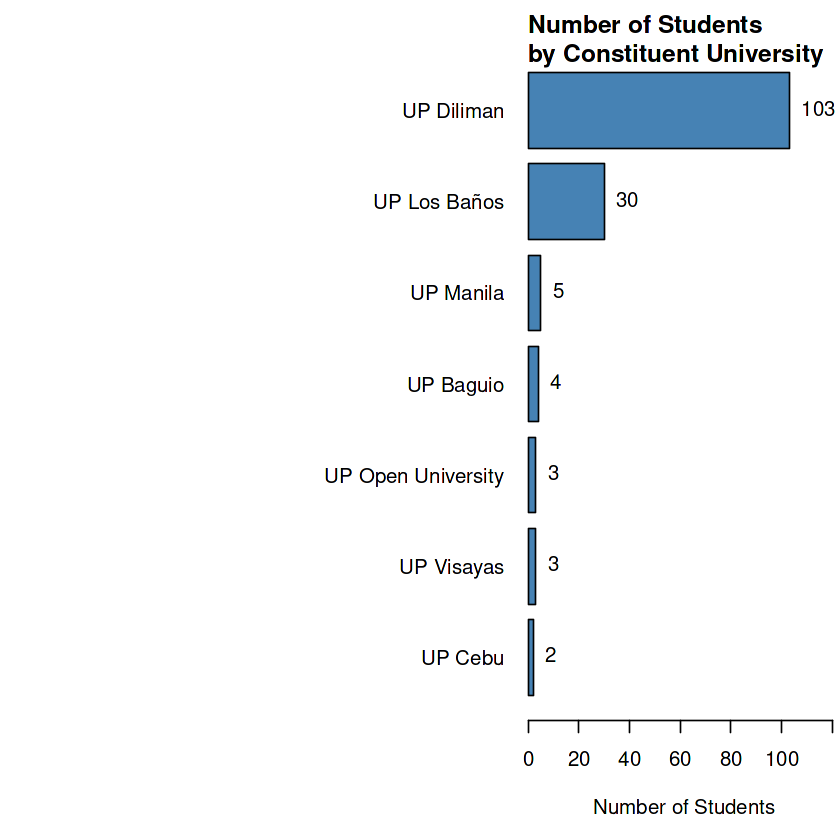

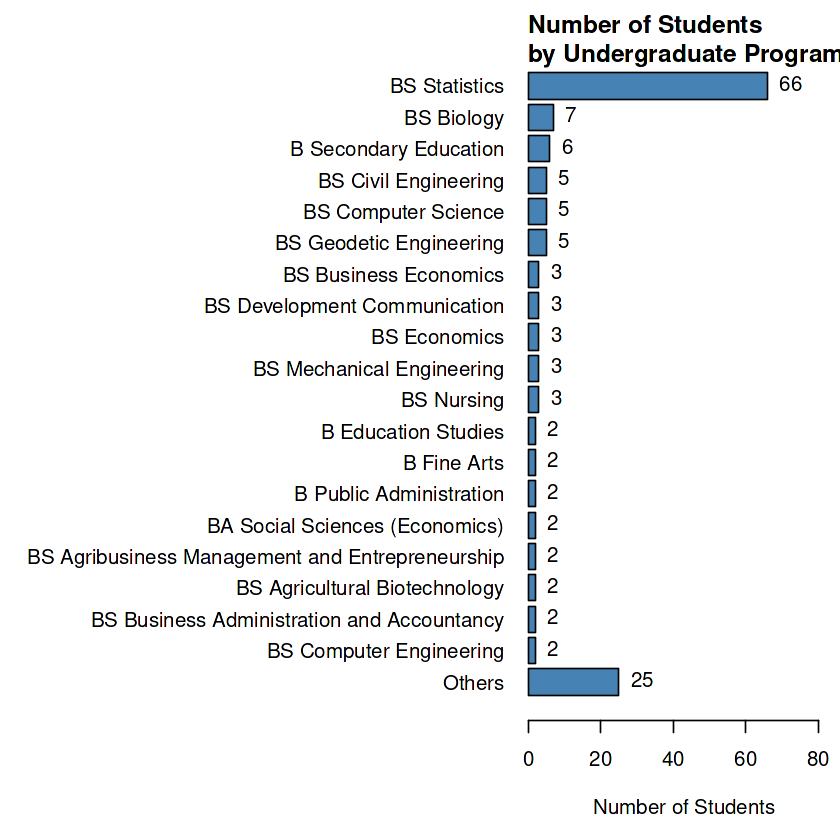

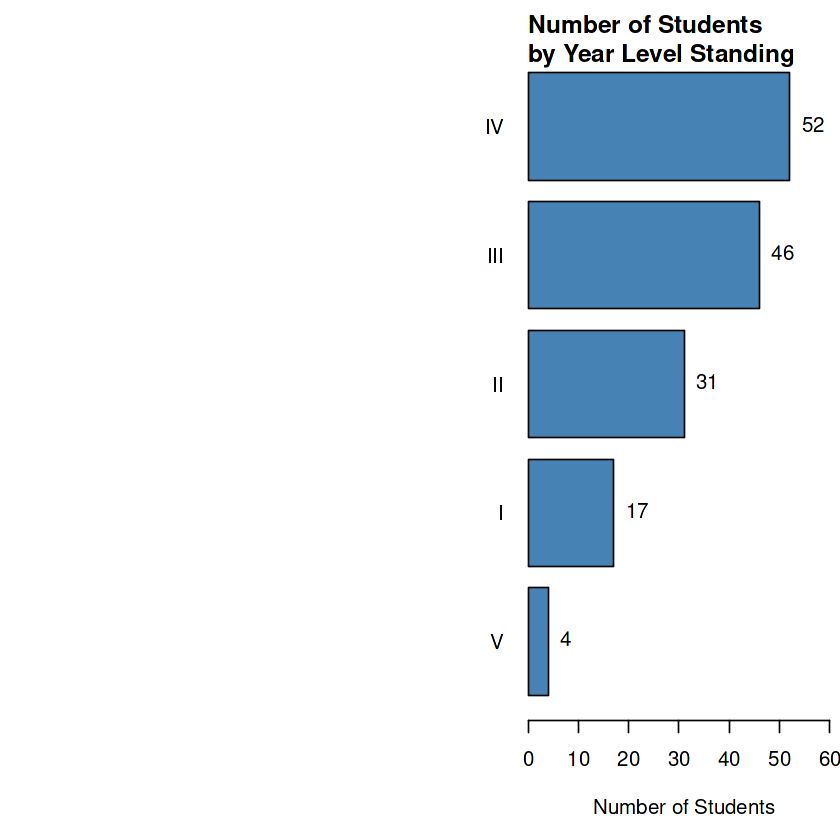

In [17]:
# Display bar plots

horiz_barplot(
  data = data,
  variable = "constituent",
  title = "\nNumber of Students\nby Constituent University",
  xlab = "Number of Students",
  mar = c(5, 22, 2, 0),
  xlim_adj = 20
)

horiz_barplot(
  data = data,
  variable = "program",
  others = TRUE,
  others.p = 1,
  title = "\nNumber of Students\nby Undergraduate Program",
  xlab = "Number of Students",
  mar = c(5, 22, 2, 0),
  xlim_adj = 20
)

horiz_barplot(
  data = data,
  variable = "year_standing",
  title = "\nNumber of Students\nby Year Level Standing",
  xlab = "Number of Students",
  mar = c(5, 22, 2, 0),
  xlim_adj = 10
)

#### 2.1.2. Student Satisfaction with Remote Learning

A student's level of agreement with the statements in the 20-item UP Student Satisfaction Scale (UPSSS), measured on a scale from 1 (Strongly Disagree) to 7 (Strongly Agree).

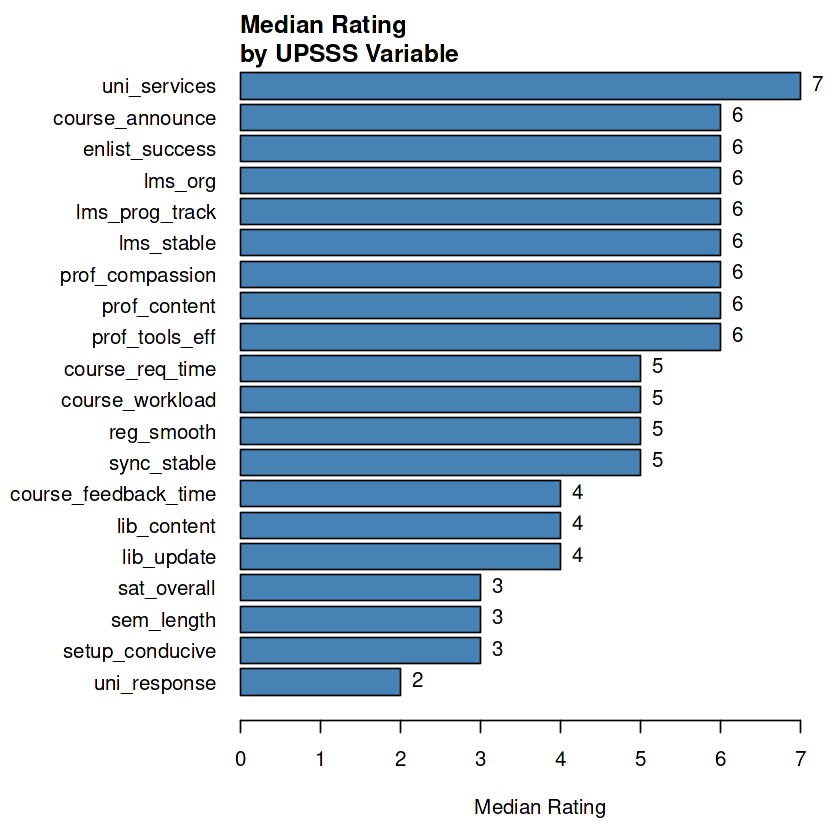

In [46]:
# Display bar plot
horiz_barplot(
  data = upsss_long,
  variable = "variable",
  summ_var="rating",
  summ_fun="median",
  title = "\nMedian Rating\nby UPSSS Variable",
  xlab = "Median Rating",
  mar = c(5, 10, 2, 0),
  xlim_adj = 0.5
)

#### 2.1.3. Perceived Academic Performance
A student's level of agreement with the statements in the 7-item Student Perception on Academic Performance Scale (SPAPS), measured on a scale from 1 (Strongly Disagree) to 7 (Strongly Agree).

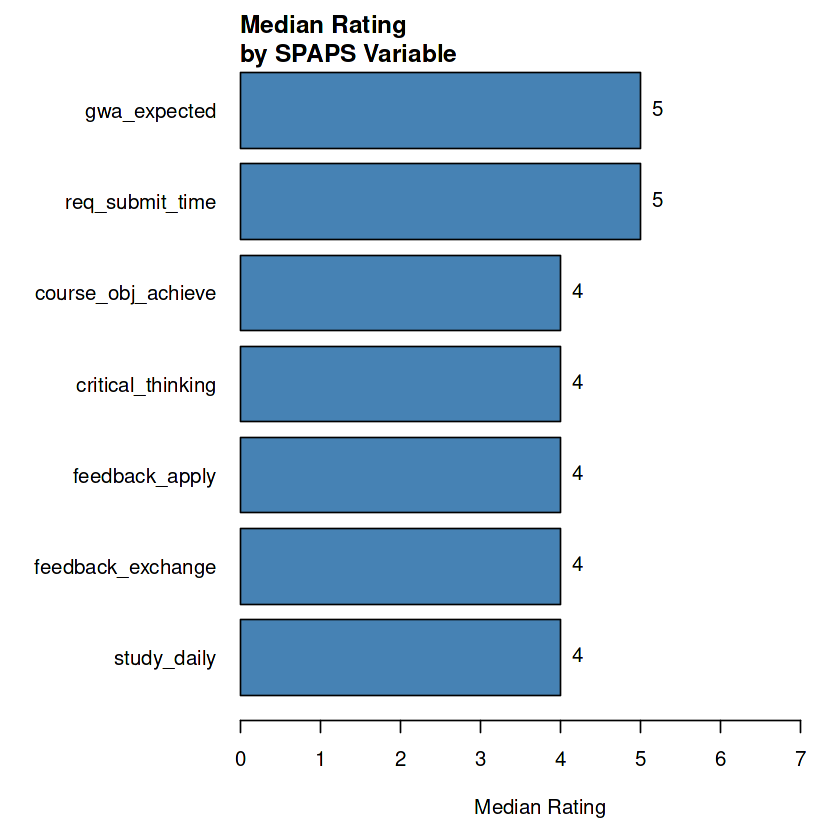

In [9]:
# Display bar plot
horiz_barplot(
  data = spaps_long,
  variable = "variable",
  summ_var="rating",
  summ_fun="median",
  title = "\nMedian Rating\nby SPAPS Variable",
  xlab = "Median Rating",
  mar = c(5, 10, 2, 0),
  xlim_adj = 2.5
)